В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [ ]:
!pip install opendatasets --upgrade --quiet

In [1]:
import opendatasets as od
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

In [2]:
# Завантажуємо дані з Kaggle

dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2/data'
od.download(dataset_url)

Skipping, found downloaded files in ".\bank-customer-churn-prediction-dlu-course-c-2" (use force=True to force download)


In [3]:
data_dir = './bank-customer-churn-prediction-dlu-course-c-2'
os.listdir(data_dir)

['sample_submission.csv', 'test.csv', 'train.csv']

In [4]:
# Зчитуємо дані train.csv в pandas dataframe

train_csv = data_dir + '/train.csv'
raw_df = pd.read_csv(train_csv)

In [5]:
# Перевіряємо який загальний вигляд мають дані

raw_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,15807989.0,Ch'iu,585.0,France,Male,33.0,3.0,0.00,1.0,1.0,0.0,54191.38,0.0
14996,14996,15731781.0,Ch'ang,678.0,France,Male,34.0,6.0,0.00,2.0,1.0,1.0,53437.10,0.0
14997,14997,15667093.0,Goliwe,678.0,France,Female,54.0,4.0,0.00,1.0,1.0,0.0,147720.29,1.0
14998,14998,15732644.0,Fanucci,705.0,Spain,Female,40.0,7.0,0.00,2.0,1.0,0.0,149550.95,0.0


Набір містить 15000 рядків і 14 стовпців. Є стовпці з числовими і категоріальними значеннями.

In [6]:
#  Розбиваємо набір на train і validation піднабори, застосовуючи стратифікацію для рівномірного розбиття за мітками класів

train_df, val_df = train_test_split(raw_df, test_size = 0.25, random_state = 42, stratify = raw_df.Exited)

In [7]:
# Перевіряємо розмір тренувального і валідаційного наборів
print('train_df.shape:', train_df.shape)
print('val_df.shape:', val_df.shape)

train_df.shape: (11250, 14)
val_df.shape: (3750, 14)


2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [8]:
# Створимо список вхідних стовпців і визначимо цільовий стовпець

input_cols = list(train_df.columns)[:-1]
target_col = list(train_df.columns)[-1]

In [9]:
print(input_cols)
print(target_col)

['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Exited


In [10]:
# Створюємо набори даних train_inputs, train_targets, val_inputs, val_targets

train_inputs = train_df[input_cols]
train_targets = train_df[target_col]

val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [11]:
# Визначаємо які стовпці є числовими

numeric_cols = train_inputs.select_dtypes(include = np.number).columns.tolist()
print('Числові стовпці:', numeric_cols)

Числові стовпці: ['id', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


In [12]:
# Визначаємо які стовпці є категоріальними

categorical_cols = train_inputs.select_dtypes(include = 'object').columns.tolist()
print('Категоріальні стовпці:', categorical_cols)

Категоріальні стовпці: ['Surname', 'Geography', 'Gender']


4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

**Перевірка на відсутність значень (їх заповнення чи видалення при потребі)**

In [13]:
#  Перевіряємо набір на наявність відсутніх значень

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


Відсутніх значень немає.

**Перевірка діапазонів числових значень, кількість унікальних значень стовпців**

In [14]:
# Перевіряємо основні статистики числових стовпців, щоб переконатись, що дані у стовпцях не мають аномалій

raw_df.describe().round(2)

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.0
mean,7499.50,15691456.68,658.94,37.74,5.03,42729.79,1.59,0.79,0.49,117784.67,0.2
std,4330.27,135205.03,72.26,8.22,2.78,59727.31,0.53,0.41,0.50,45734.45,0.4
min,0.00,1581102.00,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.0
25%,3749.75,15635143.00,603.00,32.00,3.00,0.00,1.00,1.00,0.00,83058.14,0.0
50%,7499.50,15690175.00,662.00,37.00,5.00,0.00,2.00,1.00,0.00,123584.87,0.0
75%,11249.25,15757181.50,708.00,42.00,7.00,109531.02,2.00,1.00,1.00,156884.70,0.0
max,14999.00,15815690.00,850.00,74.00,10.00,209767.31,4.00,1.00,1.00,199992.48,1.0


Значення усіх стовпців знаходяться в розумних межах. Чогось дивного немає.\
Єдине, стовпець `Balance` містить більше половини значень 0. Але це може бути допустимим і не вказувати на помилки в даних.\
З вигляду даних (стовпці мають дуже різні діапазони) можна зробити висновок, що знадобиться масштабування.

In [15]:
# Перевіряємо кількість унікальних значень у кожному стовпці

raw_df.nunique()

id                 15000
CustomerId          6348
Surname              764
CreditScore          378
Geography              3
Gender                 2
Age                   56
Tenure                11
Balance             3395
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     6242
Exited                 2
dtype: int64

**Вилучення нерелевантних для моделі ознак**

Стовпці `CustomerId` і `Surname` можна не включати до моделі (дані в них дублюються і не несуть корисної інформації).\
Стовпець `id` також не варто включати, достатньо ідентифікації рядків за їх індексами.

In [16]:
# Вилучаємо стовпці id, CustomerId, Surname як нерелевантні з тренувального і валідаційного наборів
# Оновлюємо відповідно numeric_cols і categorical_cols, що містять списки числових і категоріальних стовпців 

train_inputs = train_inputs.drop(columns = ['id', 'CustomerId', 'Surname'])
val_inputs = val_inputs.drop(columns = ['id', 'CustomerId', 'Surname'])

numeric_cols = [n for n in numeric_cols if n not in ('id', 'CustomerId')]
categorical_cols = [c for c in categorical_cols if c not in ('Surname')]

print('Числові стовпці:', numeric_cols)
print('Категоріальні стовпці:', categorical_cols)

Числові стовпці: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Категоріальні стовпці: ['Geography', 'Gender']


**Масштабування числових ознак**

In [17]:
scaler = MinMaxScaler()
scaler.fit(train_inputs[numeric_cols])

MinMaxScaler()

In [18]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

**Кодування категоріальних ознак**

Маємо два категоріальні стовпці: `Geography` і `Gender`. Їх потрібно закодувати.  

In [19]:
# Перевіряємо які унікальні значення містить стовпець Geography

raw_df['Geography'].value_counts()

France     9032
Spain      3303
Germany    2665
Name: Geography, dtype: int64

In [20]:
# Перевіряємо скільки яких унікальних значень містить стовпець Gender

raw_df['Gender'].value_counts()

Male      8529
Female    6471
Name: Gender, dtype: int64

In [21]:
# Викликаємо OneHotEncoder
# Визначаємо список категорій в усіх категоріальних стовпцях

encoder = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
encoder.fit(train_inputs[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [22]:
# Генеруємо назви стовпців для кожної окремої категорії
# Додаємо закодовані стовпці до train_inputs та val_inputs

encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])

**Перевірка поточного вигляду тренувального і валідаційного наборів**

In [23]:
display(train_inputs.head(), val_inputs.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
8263,0.632458,France,Male,0.259259,0.5,0.622726,0.000000,1.0,1.0,0.433916,1.0,0.0,0.0,0.0,1.0
14199,0.479714,Germany,Female,0.259259,0.4,0.571232,0.000000,1.0,0.0,0.888712,0.0,1.0,0.0,1.0,0.0
1856,0.591885,France,Female,0.074074,0.4,0.000000,0.333333,1.0,1.0,0.813017,1.0,0.0,0.0,1.0,0.0
3013,0.653938,France,Male,0.555556,0.3,0.000000,0.333333,1.0,0.0,0.599071,1.0,0.0,0.0,0.0,1.0
8266,0.632458,France,Female,0.314815,0.7,0.000000,0.333333,1.0,0.0,0.502109,1.0,0.0,0.0,1.0,0.0


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
1855,0.267303,France,Male,0.203704,0.9,0.570579,0.0,0.0,0.0,0.279047,1.0,0.0,0.0,0.0,1.0
1273,0.398568,Germany,Male,0.425926,0.3,0.590481,0.0,1.0,0.0,0.884371,0.0,1.0,0.0,0.0,1.0
5414,0.453461,France,Male,0.240741,0.7,0.000000,0.0,1.0,1.0,0.751226,1.0,0.0,0.0,0.0,1.0
10923,0.396181,France,Male,0.703704,0.3,0.000000,1.0,1.0,0.0,0.514675,1.0,0.0,0.0,0.0,1.0
5835,0.758950,Spain,Female,0.444444,0.5,0.000000,0.0,1.0,1.0,0.909003,0.0,0.0,1.0,1.0,0.0


Закодовані категоріальні стовпці додані в тренувальний і валідаційний набори.

In [24]:
display(train_inputs.describe().round(2), val_inputs.describe().round(2))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
count,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00
mean,0.54,0.36,0.50,0.20,0.20,0.79,0.49,0.59,0.60,0.18,0.22,0.43,0.57
std,0.17,0.15,0.28,0.29,0.18,0.41,0.50,0.23,0.49,0.38,0.41,0.49,0.49
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.41,0.26,0.30,0.00,0.00,1.00,0.00,0.42,0.00,0.00,0.00,0.00,0.00
50%,0.55,0.35,0.50,0.00,0.33,1.00,0.00,0.62,1.00,0.00,0.00,0.00,1.00
75%,0.66,0.44,0.70,0.52,0.33,1.00,1.00,0.78,1.00,0.00,0.00,1.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
count,3750.00,3750.00,3750.00,3750.00,3750.00,3750.00,3750.00,3750.00,3750.00,3750.00,3750.00,3750.00,3750.00
mean,0.54,0.37,0.50,0.20,0.20,0.78,0.49,0.59,0.61,0.17,0.22,0.45,0.55
std,0.17,0.16,0.28,0.28,0.18,0.41,0.50,0.23,0.49,0.38,0.41,0.50,0.50
min,0.01,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.41,0.26,0.30,0.00,0.00,1.00,0.00,0.41,0.00,0.00,0.00,0.00,0.00
50%,0.55,0.35,0.50,0.00,0.33,1.00,0.00,0.62,1.00,0.00,0.00,0.00,1.00
75%,0.66,0.44,0.70,0.52,0.33,1.00,1.00,0.79,1.00,0.00,0.00,1.00,1.00
max,1.00,1.04,1.00,0.89,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


Числові стовпці, які масштабувались, містять тепер значення в межах (0,1).

5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [25]:
!pip install pyarrow --quiet

In [26]:
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)

train_inputs: (11250, 15)
train_targets: (11250,)
val_inputs: (3750, 15)
val_targets: (3750,)


In [27]:
parquet_dir = './parquet_files'
if (os.path.exists(parquet_dir) == False):
  os.mkdir(parquet_dir)

train_inputs.to_parquet('./parquet_files/train_inputs.parquet')
val_inputs.to_parquet('./parquet_files/val_inputs.parquet')

pd.DataFrame(train_targets).to_parquet('./parquet_files/train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('./parquet_files/val_targets.parquet')

os.listdir(parquet_dir)

['train_inputs.parquet',
 'train_targets.parquet',
 'val_inputs.parquet',
 'val_targets.parquet']

In [28]:
# Зчитуємо дані назад і перевіряємо чи вони були завантажені правильно

train_inputs = pd.read_parquet(parquet_dir + '/train_inputs.parquet')
val_inputs = pd.read_parquet(parquet_dir + '/val_inputs.parquet')

train_targets = pd.read_parquet(parquet_dir + '/train_targets.parquet')[target_col]
val_targets = pd.read_parquet(parquet_dir + '/val_targets.parquet')[target_col]

print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)

train_inputs: (11250, 15)
train_targets: (11250,)
val_inputs: (3750, 15)
val_targets: (3750,)


In [29]:
display(train_inputs.head(), val_inputs.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
8263,0.632458,France,Male,0.259259,0.5,0.622726,0.000000,1.0,1.0,0.433916,1.0,0.0,0.0,0.0,1.0
14199,0.479714,Germany,Female,0.259259,0.4,0.571232,0.000000,1.0,0.0,0.888712,0.0,1.0,0.0,1.0,0.0
1856,0.591885,France,Female,0.074074,0.4,0.000000,0.333333,1.0,1.0,0.813017,1.0,0.0,0.0,1.0,0.0
3013,0.653938,France,Male,0.555556,0.3,0.000000,0.333333,1.0,0.0,0.599071,1.0,0.0,0.0,0.0,1.0
8266,0.632458,France,Female,0.314815,0.7,0.000000,0.333333,1.0,0.0,0.502109,1.0,0.0,0.0,1.0,0.0


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
1855,0.267303,France,Male,0.203704,0.9,0.570579,0.0,0.0,0.0,0.279047,1.0,0.0,0.0,0.0,1.0
1273,0.398568,Germany,Male,0.425926,0.3,0.590481,0.0,1.0,0.0,0.884371,0.0,1.0,0.0,0.0,1.0
5414,0.453461,France,Male,0.240741,0.7,0.000000,0.0,1.0,1.0,0.751226,1.0,0.0,0.0,0.0,1.0
10923,0.396181,France,Male,0.703704,0.3,0.000000,1.0,1.0,0.0,0.514675,1.0,0.0,0.0,0.0,1.0
5835,0.758950,Spain,Female,0.444444,0.5,0.000000,0.0,1.0,1.0,0.909003,0.0,0.0,1.0,1.0,0.0


Файли збереглись. Дані завантажились правильно.

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [30]:
# Залишаємо лише числові стовпці

X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]

In [31]:
# Навчаємо модель на тренувальних даних

model = LogisticRegression(solver='liblinear')
model.fit(X_train, train_targets)

LogisticRegression(solver='liblinear')

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [32]:
def predict_and_plot(inputs, targets, name = ''):
    
    # Прогноз
    preds = model.predict(inputs)

    # Confusion matrix
    cf = confusion_matrix(targets, preds, normalize = 'true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));
    
    # F1-score
    f1_score_ = f1_score(targets, preds, pos_label = 1)
    print(f"F1 score {name}: {f1_score_:.2f}%")
    
    # Predict probabilities
    y_pred_proba = model.predict_proba(inputs)[:, 1]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label = 1)

    # Compute AUROC
    roc_auc = auc(fpr, tpr)
    print(f'AUROC for {name}: {roc_auc:.2f}')

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
    plt.legend(loc = "lower right")
    plt.show()

    return preds

F1 score Training: 0.64%
AUROC for Training: 0.88


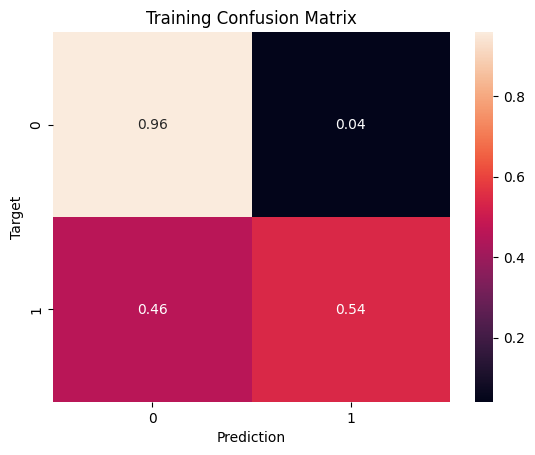

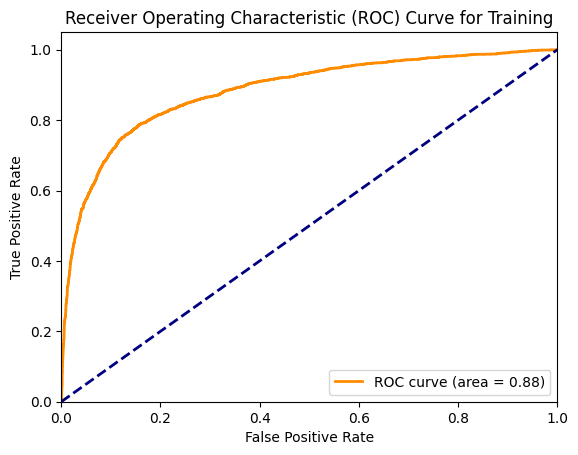

In [33]:
train_preds = predict_and_plot(X_train, train_targets, 'Training')

F1 score Validation: 0.63%
AUROC for Validation: 0.88


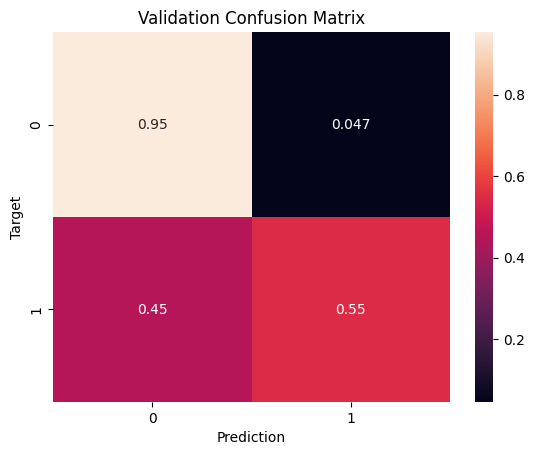

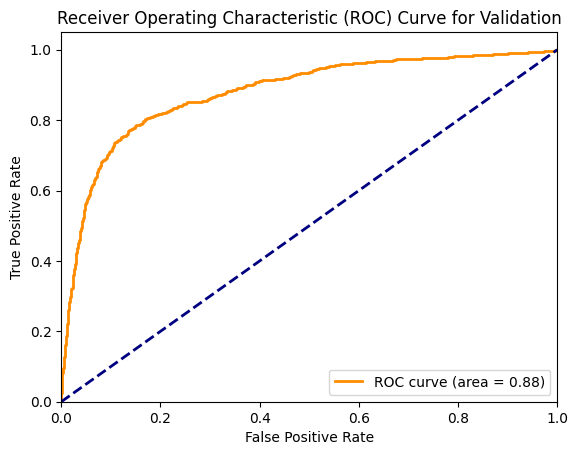

In [34]:
val_preds = predict_and_plot(X_val, val_targets, 'Validation')

Оскільки `F1-score` приблизно однаковий на наборах `train` і `val`, робимо висновок, що модель хороша.\
Метрика `AUROC` на рівні 0,88 теж свідчить, що модель досить хороша.

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [35]:
# Визначаємо якого класу більше в тренувальних даних

print(train_df.Exited.value_counts(normalize = True))

0.0    0.796533
1.0    0.203467
Name: Exited, dtype: float64


В тренувальних даних більше класу 0.

In [36]:
# Модель, що ігнорує вхідні дані і завжди повертає 0

def all_no(inputs):
    return np.full(len(inputs), 0)

In [37]:
# Функція розрахунку Accuracy

def print_accuracy(targets, preds, name = ''):
    accuracy = accuracy_score(targets, preds)
    print(f'Accuracy for {name}: {accuracy}')
    
    return accuracy

In [38]:
print_accuracy(train_targets, all_no(X_train), 'Training in Majority model')
print_accuracy(val_targets, all_no(X_val), 'Validation in Majority model')

print_accuracy(train_targets, model.predict(X_train), 'Training')
print_accuracy(val_targets, model.predict(X_val), 'Validation')

Accuracy for Training in Majority model: 0.7965333333333333
Accuracy for Validation in Majority model: 0.7965333333333333
Accuracy for Training: 0.8747555555555555
Accuracy for Validation: 0.8709333333333333


0.8709333333333333

Модель, яка завжди вибирає клас 0, дає точність приблизно 0,797.\
Побудована модель дає кращу точність – приблизно 0,874. Тобто вона краща за базову модель.\
Але все ж не варто орієнтуватись на цей показник оцінки класифікатора, оскільки модель незбалансована. 

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [39]:
bank_customer_churn_prediction = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [40]:
joblib.dump(bank_customer_churn_prediction, 'bank_customer_churn_prediction.joblib')

['bank_customer_churn_prediction.joblib']

In [41]:
model_2 = joblib.load('bank_customer_churn_prediction.joblib')

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [42]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [43]:
# Набір, для якого будуть рахуватись ймовірності належності до класу 1

raw_df[:5]

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [44]:
# Розрахунок ймовірності належності крожного рядка в наборі до класу 1

predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, raw_df[:5])

array([0.00642569, 0.03706968, 0.36971138, 0.37670638, 0.97583457])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [45]:
# Зчитування тестового набору даних

test_csv = data_dir + '/test.csv'
test_raw_df = pd.read_csv(test_csv)

In [46]:
# Передбачення для кожного рядка тестового набору і його запис в новий стовпець Exited в датафреймі test_raw_df

test_pred = predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, test_raw_df)
test_raw_df['Exited'] = test_pred

In [47]:
# Перевірка вигляду датафрейму після додання стовпця Exited

test_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Exited
0,15000,15594796.0,Chu,0.365155,Germany,Male,0.222222,0.2,0.696265,0.000000,1.0,1.0,0.789477,0.0,1.0,0.0,0.0,1.0,0.074950
1,15001,15642821.0,Mazzi,0.286396,France,Male,0.388889,0.5,0.000000,0.333333,1.0,1.0,0.337131,1.0,0.0,0.0,0.0,1.0,0.034767
2,15002,15716284.0,Onyekachi,0.656325,France,Male,0.462963,0.8,0.000000,0.333333,1.0,0.0,0.783859,1.0,0.0,0.0,0.0,1.0,0.150961
3,15003,15785078.0,Martin,0.682578,Spain,Male,0.500000,0.3,0.000000,0.000000,1.0,1.0,0.834571,0.0,0.0,1.0,0.0,1.0,0.196458
4,15004,15662955.0,Kenechukwu,0.384248,Spain,Male,0.462963,0.8,0.000000,0.333333,1.0,1.0,0.718421,0.0,0.0,1.0,0.0,1.0,0.055247


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [48]:
# Зчитування файлу і перевірка його вигляду

submission_csv = data_dir + '/sample_submission.csv'
submission_df = pd.read_csv(submission_csv)
submission_df.head()

,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5


In [49]:
# Перевірка чи співпадають id у тестовому датафреймі і submission_df

res = test_raw_df['id'] == submission_df['id']
print(res)

0       True
1       True
2       True
3       True
4       True
        ... 
9995    True
9996    True
9997    True
9998    True
9999    True
Name: id, Length: 10000, dtype: bool


In [50]:
res.value_counts()

True    10000
Name: id, dtype: int64

Всі значення поля `id` співрадають у двох датафреймах. Можна заповнювати поле `Exited` порахованими значеннями.

In [51]:
submission_df.Exited = test_raw_df.Exited
submission_df.head()

,id,Exited
0,15000,0.074950
1,15001,0.034767
2,15002,0.150961
3,15003,0.196458
4,15004,0.055247


In [52]:
submission_df.to_csv('submission_log_reg.csv', index = False)